# Data Science 1 - Signal analysis

## Lesson 2 - Spline interpolation

&copy; 2021, dr.ir. Dave R.M. Langers (LADR, ZP11/H1.90, [d.r.m.langers@pl.hanze.nl](mailto:d.r.m.langers@pl.hanze.nl))

<img src="https://bioinf.nl/~davelangers/dave.png" width="10%" height="10%" alt="Dave Langers" /> 

<small>**Note:** step forward using `SPACE` or backward using `SHIFT`+`SPACE`, or use the arrows in the bottom right to navigate; run code cells using `CTRL`+`ENTER`.</small>

In [1]:
# Initialization

%matplotlib inline
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from IPython.display import display
from lesson2 import figure

### Main material

*Numerical methods in engineering with python 3*, **chapter 3.3**

<img src="https://images-na.ssl-images-amazon.com/images/I/51963RBvJDL._SX348_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Numerical methods in engineering with python 3" />

*Hands-on Signal Analysis with Python: An Introduction*, **chapter 5.5.2, 6.3, 6.3.1 & 6.3.2**

<img src="https://images-na.ssl-images-amazon.com/images/I/41CaMa-FgDS._SX375_BO1,204,203,200_.jpg" width="5%" height="5%" alt="Hands-on Signal Analysis with Python: An Introduction" />

### <a id="/1">Lesson 2 - Spline interpolation</a>

* <u>Part 2A</u><br />*Introduction*

* <span style="color:#336699"><a href="#/7">Part 2B</a><br />Nearest-neighbor interpolation</span>

* <span style="color:#336699"><a href="#/11">Part 2C</a><br />Linear spline interpolation</span>

* <span style="color:#336699"><a href="#/16">Part 2D</a><br />Cubic spline interpolation</span>

### Global versus local interpolation

*Global* and *local* interpolation differ in the number of data points that are used to infer the unknown $y$ for a particular $x$.

* Global interpolation makes use of all $n$ data points.<br />
  *Example:* polynomial interpolation.
  
* Local interpolation only uses a limited subset of nearby data points.<br />
  *Example:* spline interpolation.

For (moderately) large amounts of data, high-degree polynomials result in unfaithful interpolation due to [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon). The use of a [piecewise polynomial](https://en.wikipedia.org/wiki/Piecewise) as interpolant, also known as a [spline](https://en.wikipedia.org/wiki/Spline_(mathematics)), allows the degree of the employed polynomials to be reduced.

Piecewise polynomials are defined by segments consisting of distinct polynomial equations between certain *knots* $x_1 < x_2 < \ldots < x_n$. For example, for a quadratic spline,

$$
y(x) = \left\{
\begin{array}{cl}
p_1(x) = a_{21} x^2 + a_{11} x + a_{01} & \text{for } x_1 \leq x < x_2
\\
p_2(x) = a_{22} x^2 + a_{11} x + a_{01} & \text{for } x_2 \leq x < x_3
\\
\vdots &
\\
p_{n-1}(x) = a_{2,n-1} x^2 + a_{1,n-1} x + a_{0,n-1} & \text{for } x_{n-1} \leq x < x_n
\end{array}
\right.
$$

I.e., different intervals are described by polynomials with different coefficiënts.

For splines, we typically take the knots to coincide with data points. If these are all equidistant, the spline is said to be *uniform*.

### Types of splines

Depending on the degree of the piecewise polynomial, different splines are obtained:

* *zero* splines for 0<sup>th</sup> degree polynomials

* *linear* splines for 1<sup>st</sup> degree polynomials

* *quadratic* splines for 2<sup>nd</sup> degree polynomials

* *cubic* splines for 3<sup>rd</sup> degree polynomials

Higher-degree polynomials can be used, but are less common.

<small>**Note:** in addition to a zero spline, the is also a *nearest-neighbor*  spline that places the knots midway between the data points.</small>

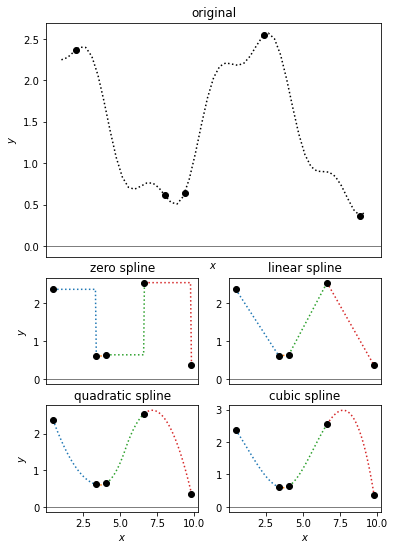

Figure 1: Types of splines


In [2]:
figure(1)

The coefficients of the piecewise polynomials $a_{ij}$ can be fixed by imposing a series of *continuity constraints*.

1. **Left-continuity:** At $x_i$, the polynomial $p_i(x)$ should evaluate to $y_i$.<br />
   I.e., each segment should connect to the data point $(x_i, y_i)$ on the left.

2. **Right-continuity:** At $x_{i+1}$, the polynomial $p_i(x)$ should evaluate to $y_{i+1}$.<br />
   I.e., each segment should connect to the data point $(x_{i+1}, y_{i+1})$ on the right.

3. **Straightness:** At $x_i$, the 1<sup>st</sup> derivative of the left polynomial $\frac{\text{d}}{\text{d}x} p_{i-1}(x)$ should match the 1<sup>st</sup> derivative of the right polynomial $\frac{\text{d}}{\text{d}x} p_i(x)$.<br />
   I.e., the segments should connect in a straight fashion.

4. **Smoothness:** At $x_i$, the 2<sup>nd</sup> derivative of the left polynomial $\frac{\text{d}^2}{\text{d}x^2} p_{i-1}(x)$ should match the 2<sup>nd</sup> derivative of the right polynomial $\frac{\text{d}^2}{\text{d}x^2} p_i(x)$.<br />
   I.e., the segments should connect in a smooth fashion.

For higher-degree polynomials, higher derivatives can be matched.

The various types of splines satisfy an increasing number of these constraints.

* A zero spline is fully defined by the first constraint alone.<br />
  It generally does not satisfy the other constraints: the interpolant is discontinuous.

* A linear spline is fully defined by the first and second constraints.<br />
  It generally does not satisfy the straightness and smoothness constraints: the interpolant is continuous but its slope is not.

* A quadratic spline is fully defined by the first to third constraints.<br />
  It generally does not satisfy the smoothness constraint: the interpolant's slope is continuous but its curvature is not.

* A cubic spline is fully defined by the first to fourth constraints.<br />
  The interpolant's slope and curvature are continuous.

<small>**Note:** some variations of (cubic) splines combine a subset of constraints with some additional other conditions.</small>

### Example

Consider the following data regarding the monthly number of confirmed Covid cases in the municipality of Groningen (from: [Coronavirus Dashboard](https://coronadashboard.government.nl/landelijk/positief-geteste-mensen)).

| Year | Month | Cases |   | Year | Month | Cases |
| ---- | ----- | ----- | - | ---- | ----- | ----- |
| 2020 | -     | -     |   | 2021 | Jan   | 1399  |
|      | Mar   | 92    |   |      | Mar   | 1590  |
|      | May   | 7     |   |      | May   | 1261  |
|      | Jul   | 16    |   |      | Jul   | 5690  |
|      | Sep   | 885   |   |      | Sep   | 670   |
|      | Nov   | 849   |   |      | Nov   | 3271  |

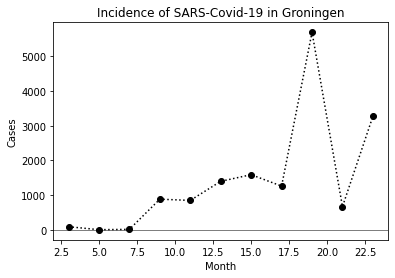

In [3]:
months = np.arange(3, 24, 2)
cases = np.array([
    92, 7, 16, 885, 849,
    1399, 1590, 1261, 5690, 670, 3271
])

plt.axhline(0.0, color='k', lw=0.5)
plt.plot(months, cases, 'o:k')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.show()

The `scipy.interpolate` module provides the `interp1d()` class that implements spline interpolation. Required arguments are vectors $\boldsymbol{x}$ and $\boldsymbol{y}$.

You may supply the type of spline interpolation by setting the `kind` argument; the default is interpolation with a `'linear'` spline.

<small>**Note:** by setting `fill_value='extrapolate'`, the spline can extrapolate to values of $x$ outside the measured interval; however, such estimates are often unreliable.</small>

In [4]:
from scipy.interpolate import interp1d
help(interp1d)

Help on class interp1d in module scipy.interpolate.interpolate:

class interp1d(scipy.interpolate.polyint._Interpolator1D)
 |  interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
 |  
 |  Interpolate a 1-D function.
 |  
 |  `x` and `y` are arrays of values used to approximate some function f:
 |  ``y = f(x)``. This class returns a function whose call method uses
 |  interpolation to find the value of new points.
 |  
 |  Parameters
 |  ----------
 |  x : (N,) array_like
 |      A 1-D array of real values.
 |  y : (...,N,...) array_like
 |      A N-D array of real values. The length of `y` along the interpolation
 |      axis must be equal to the length of `x`.
 |  kind : str or int, optional
 |      Specifies the kind of interpolation as a string or as an integer
 |      specifying the order of the spline interpolator to use.
 |      The string has to be one of 'linear', 'nearest', 'nearest-up', 'zero',
 |      'slinear', 'quadrati

The resulting `interp1d` object is callable and behaves like a function. It will return the value of the spline for certain $x$.

In [5]:
spline = interp1d(months, cases, kind='quadratic')
spline(12.0)

array(1073.53046141)

Among other things, the spline object contains the $(x_i, y_i)$ values of all knots.

In [6]:
spline.x

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

In [7]:
spline.y

array([  92.,    7.,   16.,  885.,  849., 1399., 1590., 1261., 5690.,
        670., 3271.])

When we interpolate the number of cases for intermediate months in 2020 and 2021, we observe that the measured data are exactly reproduced by the interpolant.

In comparison with interpolation with a single global polynomial, oscillations are much reduced.

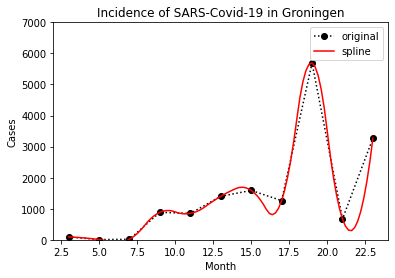

In [8]:
x = np.linspace(3, 23, 101)
y = spline(x)

plt.axhline(0., color='k', lw=.5)
plt.plot(months, cases, 'o:k', label='original')
plt.plot(x, y, '-r', label='spline')
plt.xlabel('Month'); plt.ylabel('Cases')
plt.title('Incidence of SARS-Covid-19 in Groningen')
plt.legend(); plt.ylim(0.0, 7.0e3); plt.show()

### Implementations in `scipy` and `pandas`

Apart from `interp1d()`, the `scipy.interpolate` module contains various other callable classes that perform spline interpolation based on vectors $\boldsymbol{x}$ and $\boldsymbol{y}$.
  
<small>**Note:** in contrast to `interp1d()`, these other interpolators do provide access to the polynomial coefficients $a_{ij}$ through a property `c`.</small>

* `Akima1DInterpolator()` fits a non-smoothing [Akima](https://en.wikipedia.org/wiki/Akima_spline) cubic spline that is able to deal more robustly with functions with rapidly varying curvature, at the cost of no longer satisfying the smoothness constraint.
  
<small>**Note:** this spline function does not extrapolate.</small>

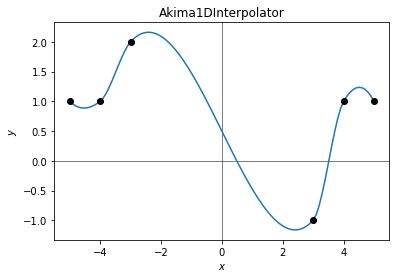

Figure 2: Akima1DInterpolator


In [9]:
figure(2)

* `CubicSpline()` fits a [cubic Hermite spline](https://en.wikipedia.org/wiki/Cubic_Hermite_spline) with selectable types of boundary conditions.

  * `bc_type='not-a-knot'`: the first and second segment are the same polynomial.
  
  * `bc_type='periodic'`: the function value and its derivatives at the last knot match those at the first knot.
  
  * `bc_type='clamped'`: the 1<sup>st</sup> derivatives at the first and last knot equal zero.
  
  * `bc_type='natural'`: the 2<sup>nd</sup> derivatives at the first and last knot equal zero.

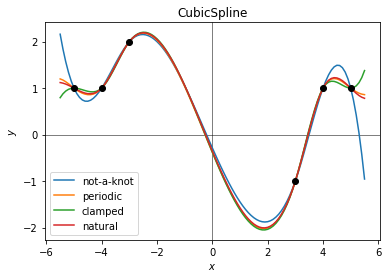

Figure 3: CubicSpline


In [10]:
figure(3)

* `PchipInterpolator()` fits a *Piecewise Cubic Hermite Interpolating Polynomial* spline that does not introduce additional extrema (i.e., minima or maxima) except those that coincide with knots.
  
<small>**Note:** this class has an accompanying `pchip_interpolate()` function with arguments `xi`, `yi` and `x` that fits and applies the spline in one call.</small>

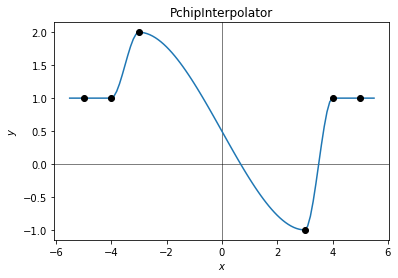

Figure 4: PchipInterpolator


In [11]:
figure(4)

* `CubicHermiteSpline()` fits a cubic spline for which derivatives at knots are specified in addition to function values.

<small>**Note:** in the example, the slope in all knots is set equal to 1.</small>

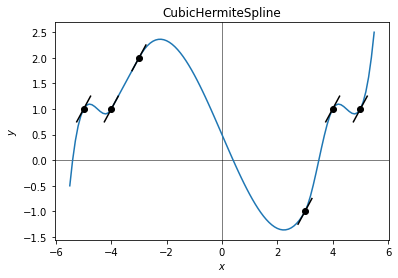

Figure 5: CubicHermiteSpline


In [12]:
figure(5)

In `pandas`, the `Series` as well as the `DataFrame` objects expose an `interpolate()` method with an argument `method` with possible values `'zero'`, `'linear'`, `'quadratic'`, `'cubic'`, but also `'cubicspline'`, `'akima'`, `'pchip'`, and  `'nearest'`. These can impute missing values from the available other data by means of spline interpolation.

In [13]:
quadratic = pd.DataFrame({
    '$y_i$': [0, 1, np.nan, np.nan, 16, 25, np.nan, 49]
}).rename_axis('$x_i$')
for method in ('zero', 'linear', 'quadratic', 'cubic', 'akima', 'cubicspline', 'pchip', 'nearest'):
    column = '$y_{i,\text{' + method + '}}$'
    quadratic[column] = quadratic['$y_i$'].interpolate(method=method)

quadratic

,$y_i$,"$y_{i,\text{zero}}$","$y_{i,\text{linear}}$","$y_{i,\text{quadratic}}$","$y_{i,\text{cubic}}$","$y_{i,\text{akima}}$","$y_{i,\text{cubicspline}}$","$y_{i,\text{pchip}}$","$y_{i,\text{nearest}}$"
$x_i$,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0
2,NaN,1.0,6.0,4.0,4.0,4.603175,4.0,4.055556,1.0
3,NaN,1.0,11.0,9.0,9.0,9.539683,9.0,9.444444,16.0
4,16.0,16.0,16.0,16.0,16.0,16.000000,16.0,16.000000,16.0
5,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.0
6,NaN,25.0,37.0,36.0,36.0,36.303571,36.0,36.031250,25.0
7,49.0,49.0,49.0,49.0,49.0,49.000000,49.0,49.000000,49.0


### Exercise 1

Construct cubic spline curves using the `interp1d()` and `Akima1DInterpolator()` functions for the number of SARS-Covid-19 cases from March '20 to November '21. Which interpolator does best?

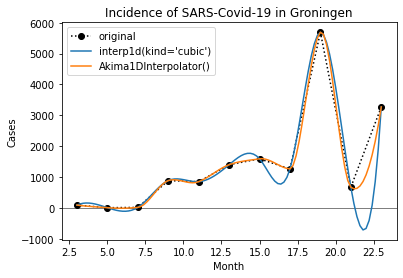

### Exercise 2

The following code snippet extracts data regarding the population size of the Netherlands (from: [Wikipedia](https://en.wikipedia.org/wiki/Demography_of_the_Netherlands#/Births_and_deaths)) from 1900 onwards into a `pandas` dataframe named `population`.

```python
from urllib.request import urlopen
url = 'https://en.wikipedia.org/wiki/Demography_of_the_Netherlands'
html = urlopen(url).read().decode('utf-8').replace('\n', '')
from re import findall
data = findall('<td>([0-9]{4})</td><td>([0-9]+)</td>', html.replace(',', ''))
population = pd.DataFrame(data, columns=['years', 'sizes']).apply(pd.to_numeric)
```

Plot the Dutch population size together with piecewise polynomial spline curves of degree 0 to 3, interpolated from the year 2000, and extrapolated until 2025. Which spline would you consider most appropriate here?

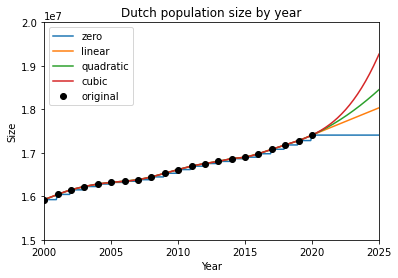

### Exercise 3

Below, some observations are provided regarding the size of a moose population in Michigan (from: [Wolves & Moose from Isle Royal](https://isleroyalewolf.org/data/data/home.html)).

```python
years = np.arange(1959, 2020)
moose = np.array([
    538, 564, 572, 579, 596, 620, 634, 661, 766, 848, 1041, 1045, 1183,
    1243,1215, 1203, 1139, 1070, 949, 845, 857, 788, 767, 780, 830, 927,
    976, 1014, 1046, 1116, 1260, 1315, 1496, 1697, 1784, 2017, 2117,
    2398, 900, 925, 997, 1031, 1120, 1100, 900, 750, 540, 450, 385,
    650, 530, 510, 515, 750, 975, 1050, 1250, 1300, 1600, 1475, 2060
])
```

Plot the population across the available years, and include a trendline based on a spline function. Subsequently, overlay a spline through only the subset of the data that corresponds with years that are a multiple of five (i.e. 1960, 1965, ..., 2015) in a different color. In each case, choose a suitable spline degree.

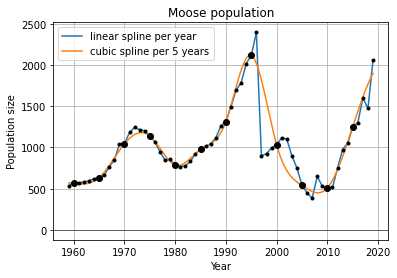

### Exercise 4

Below you find the average temperature in the city of Groningen across all months in a year (from: [Climates to travel](https://www.climatestotravel.com/climate/netherlands/groningen)). These data are periodic in the sense that the month December is followed by January, after which the data cycle.

| Month     | T [°C] |   | Month     | T [°C] |
| --------- | ------ | - | --------- | ------ |
| January   |  2.5   |   | July      | 17.5   |
| February  |  2.9   |   | August    | 17.2   |
| March     |  5.5   |   | September | 14.2   |
| April     |  8.9   |   | October   | 10.2   |
| May       | 12.4   |   | November  |  6.1   |
| June      | 15.1   |   | December  |  3.3   |

Plot these data together with a *periodic* cubic spline curve.

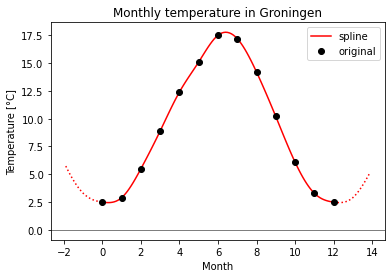

### Exercise 5

The below code fragment loads the respiratory volume of a subject while standing breathing normally (first half minute) or breathing deeply (second half minute) according to a sensor placed around the thorax (from: [biosignalsplux](https://biosignalsplux.com/learn/samples.html)).

```python
url = 'http://biosignalsplux.com/downloads/samples/respiration-rip/SampleRIP_converted.txt'
respiration = pd.read_csv(url, sep='\t', dtype=float, comment='#',
              usecols=[0, 2], names=['Time [s]', 'Volume [L]']).loc[::500, :]
respiration['Time [s]'] = respiration['Time [s]'] * 1e-3
```

Plot the measured signal together with an interpolated curve. Include a horizontal line that indicates the average respiratory volume.

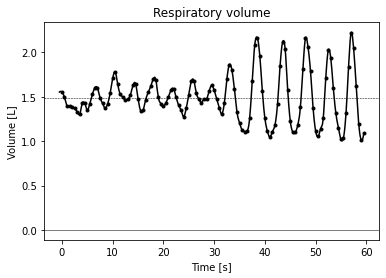

### <a id="/7">Lesson 2 - Spline interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 2A</a><br />Introduction</span>

* <u>Part 2B</u><br />*Nearest-neighbor interpolation*

* <span style="color:#336699"><a href="#/11">Part 2C</a><br />Linear spline interpolation</span>

* <span style="color:#336699"><a href="#/16">Part 2D</a><br />Cubic spline interpolation</span>

### Nearest-neighbor interpolation

[Nearest-neighbor interpolation](https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation) constructs piecewise 0<sup>th</sup>-degree polynomials between knots that lie midway between the data points.

Therefore, the spline assigns the $y_i$ value of the data point with an $x_i$ that is closest to the requested $x$.

<small>**Note:** at the knots, the tie is broken arbitrarily.</small>

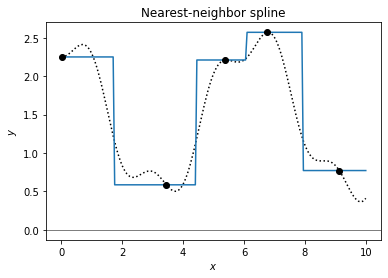

Figure 6: Nearest-neighbor spline


In [19]:
figure(6)

### Example

We wish to find the value $y(x)$ at $x=\frac{4}{3}$ of the nearest-neighbor spline that passes through the points $(0,0)$, $(1,\frac{1}{2})$, $(2,2)$, and $(3,\frac{1}{2})$.

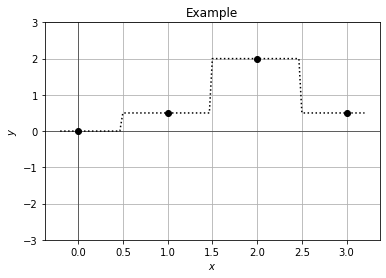

Figure 7: Example


In [20]:
figure(7)

First, we construct the knots that lie midway between the data points, resulting in $\boldsymbol{x}_\text{knot} = \left[ \frac{1}{2}, \frac{3}{2}, \frac{5}{2} \right]$.

Then we determine that $x=\frac{4}{3}$ lies between the knots $x_{\text{knot},1}=\frac{1}{2}$ and $x_{\text{knot},2}=\frac{3}{2}$, and is therefore on the segment of the piecewise constant polynomial that surrounds data point $(x_2, y_2) = (1, \frac{1}{2})$.

Therefore, we conclude that $y(\frac{4}{3})$ equals $y_2 = \frac{1}{2}$.

### Exercise 6

Manually determine the value $y(x)$ at coordinate $x=3$ for the uniform nearest-neighbor spline that passes through the points $(0,-1)$, $(2,0)$, $(4,3)$, $(6,3)$, $(8,3)$, and $(10,1)$.

### Exercise 7

Complete the below skeleton function `nearest_interpolate()` that interpolates between a number of given data points that are specified in arrays `xi` and `yi` using nearest-neighbor spline interpolation, and calculates the $y$-values that correspond with all the $x$-values that are requested.

<small>**Note:** the function `np.searchsorted()` may prove useful.</small>

```python
def nearest_interpolate(xi, yi, x):
    """y = nearest_interpolate(xi, yi, x).
    Nearest-neighbor spline interpolation method that
    fits a piecewise polynomial of degree zero through
    data points {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    order = np.argsort(xi)
    xi, yi = xi[order], yi[order]
    pass   # ADD YOUR OWN CODE HERE
    return y
```

### Exercise 8

Apply your own function `nearest_interpolate()` to verify your solution for exercise 6.

y(3.0) = 0.0


### Exercise 9

Compare the output of your own function `nearest_interpolate()` to that of `scipy`'s `interp1d(kind='nearest')` function for the data from exercise 1.

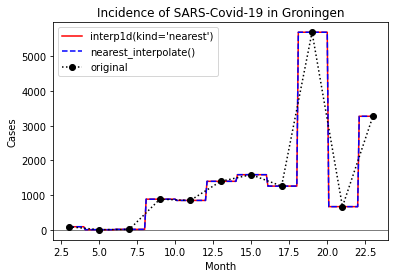

### <a id="/11">Lesson 2 - Spline interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 2A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/7">Part 2B</a><br />Nearest-neighbor interpolation</span>

* <u>Part 2C</u><br />*Linear spline interpolation*

* <span style="color:#336699"><a href="#/16">Part 2D</a><br />Cubic spline interpolation</span>

### Linear spline interpolation

For linear spline interpolation, a 1<sup>st</sup>-degree polynomial

$$
y(x) = p_i(x) = a_{1i} \cdot x + a_{0i}
$$

is interpolated between every pair of adjacent ordered knots $(x_i,y_i)$ and $(x_{i+1},y_{i+1})$.

<small>**Note:** the polynomial that describe the first and last segment can also be used to extrapolate data outside of the measured interval.</small>

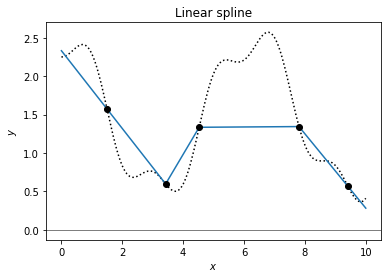

Figure 8: Linear spline


In [24]:
figure(8)

By imposing left- and right-continuity constraints, the coefficients must satisfy

$$
\left\{
\begin{aligned}
y_i &= a_{1i} \cdot x_i + a_{0i}
\\
y_{i+1} &= a_{1i} \cdot x_{i+1} + a_{0i}
\end{aligned}
\right.
$$

This resolves (e.g. using [Cramer's rule](https://en.wikipedia.org/wiki/Cramer%27s_rule)) to the solution

$$
\left\{
\begin{aligned}
a_{1i} &= \frac{y_{i+1}-y_i}{x_{i+1}-x_i}
\\
a_{0i} &= \frac{x_{i+1} y_i - x_i y_{i+1}}{x_{i+1}-x_i}
\end{aligned}
\right.
$$

These coefficients are used to interpolate $y(x)$ for new values $x$ in the range $x_i \leq x < x_{i+1}$.

### Weighted averaging

An alternative view on the same construction is to regard the linear spline as a *weighted average* of two 0<sup>th</sup> degree polynomials:

* a constant function $q_i(x) = x_i$ through the left knot alone, and

* a constant function $q_{i+1}(x) = x_{i+1}$ through the right knot alone

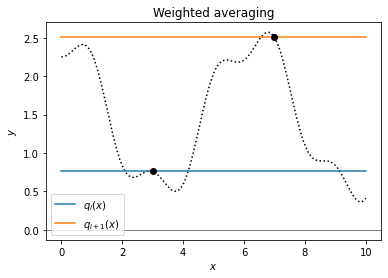

Figure 9: Weighted averaging


In [25]:
figure(9)

The linear spline can then be constructed by combining these polynomials in weighted fashion.

The weights depends on $x$:

* the weight $w_i(x)$ of the left polynomial is set to 1 at $x_i$, and decreases to 0 at $x_{i+1}$

* the weight of the right polynomial is set to $1 - w_i(x)$

As a result, the weighted polynomial will pass through the left knot on the left, and through the right knot on the right.

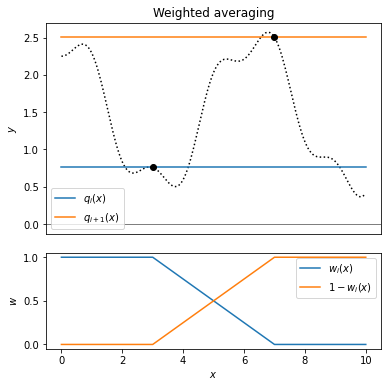

Figure 10: Weighted averaging


In [26]:
figure(10)

We find that

$$
w_i(x) = \frac{x_{i+1}-x}{x_{i+1}-x_i}
$$

giving rise to the following equation for the 1<sup>st</sup>-degree polynomial segment of the spline

$$
\begin{aligned}
p_i(x) &= w_i(x) \cdot q_i(x) + \left( 1-w_i(x) \right) \cdot q_{i+1}(x)
\\
&= \frac{x_{i+1}-x}{x_{i+1}-x_i} \cdot y_i + \frac{x-x_i}{x_{i+1}-x_i} \cdot y_{i+1}
\end{aligned}
$$

Verify that this is equivalent to the equations for $a_{1i}$ and $a_{0i}$.

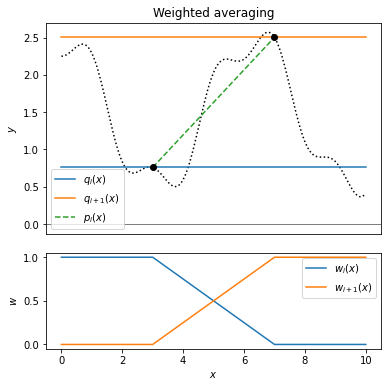

Figure 11: Weighted averaging


In [27]:
figure(11)

### Example

We wish to find the value $y(x)$ at $x=\frac{4}{3}$ of the linear spline that passes through the points $(0,0)$, $(1,\frac{1}{2})$, $(2,2)$, and $(3,\frac{1}{2})$.

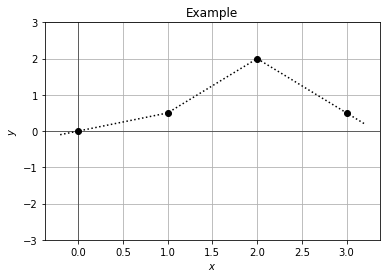

Figure 12: Example


In [28]:
figure(12)

We determine that $x=\frac{4}{3}$ lies between the knots $x_{\text{knot},2}=1$ and $x_{\text{knot},3}=2$, and is therefore on the segment of the piecewise linear polynomial between data points $(x_2, y_2) = (1, \frac{1}{2})$ and $(x_3, y_3) = (2, 2)$.

The coefficients then equal $a_{12} = \frac{2-\frac{1}{2}}{2-1} = \frac{3}{2}$ and $a_{02} = \frac{2 \cdot \frac{1}{2} - 1 \cdot 2}{2-1} = -1$. Therefore, we conclude that $y(x) = \frac{3}{2}x-1$, such that $y(\frac{4}{3}) = 1$.

### Exercise 10

Manually determine the value $y(x)$ at coordinate $x=3$ for the uniform linear spline that passes through the points $(0,-1)$, $(2,0)$, $(4,3)$, $(6,3)$, $(8,3)$, and $(10,1)$.

### Exercise 11

Complete the below skeleton function `linear_interpolate()` that interpolates between a number of given data points that are specified in arrays `xi` and `yi` using linear spline interpolation, and calculates the $y$-values that correspond with all the $x$-values that are requested.

```python
def linear_interpolate(xi, yi, x):
    """y = linear_interpolate(xi, yi, x).
    Linear spline interpolation method that fits a
    piecewise polynomial of degree one through
    data points {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    order = np.argsort(xi)
    xi, yi = xi[order], yi[order]
    pass   # ADD YOUR OWN CODE HERE
    return y
```

### Exercise 12

Apply your own function `linear_interpolate()` to verify your solution for exercise 10.

y(3.0) = 1.5


### Exercise 13

Compare the output of your own function `linear_interpolate()` to that of `scipy`'s `interp1d(kind='linear')` function for the data from exercise 1.

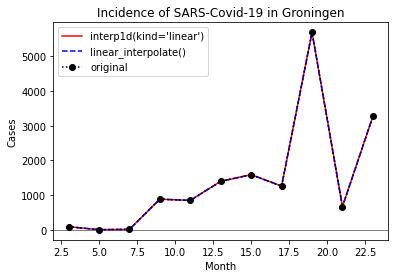

### <a id="/16">Lesson 2 - Spline interpolation</a>

* <span style="color:#336699"><a href="#/1">Part 2A</a><br />Introduction</span>

* <span style="color:#336699"><a href="#/7">Part 2B</a><br />Nearest-neighbor interpolation</span>

* <span style="color:#336699"><a href="#/11">Part 2C</a><br />Linear spline interpolation</span>

* <u>Part 2D</u><br />*Cubic spline interpolation*

### Cubic spline interpolation

As we have seen, there are numerous types of cubic spline methods that differ in the constraints that are imposed.

* In the *Numerical methods in engineering with python 3* textbook, a cubic spline with natural boundary conditions is derived, i.e. `CubicSpline(bc_type='natural')`.

* In the *Hands-on Signal Analysis with Python: An Introduction* textbook, a cubic spline with matching first and second segments is employed, i.e. `CubicSpline(bc_type='not-a-knot')`.

Here, we will follow a different approach that extends the weighted averaging method.

<small>**Note:** if you prefer, you are free to study and implement either of the other cubic spline methods.</small>

### Weighted averaging

A cubic spline can be constructed as a *weighted average* of two 2<sup>nd</sup> degree polynomials:

* a parabola $q_i(x)$ through the left knot and its two direct neighbors, and

* a parabola $q_{i+1}(x)$ through the right knot and its two direct neighbors

Again, the weights are chosen identically to those in the linear interpolation section such that the weighted polynomial transitions from the left to the right knot.

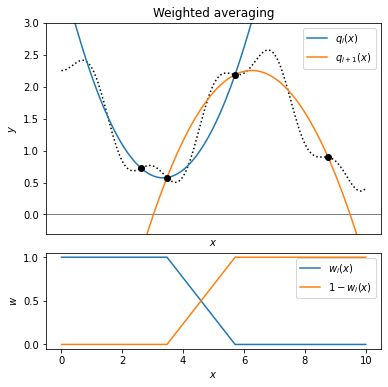

Figure 13: Weighted averaging


In [32]:
figure(13)

Similar to the Akima cubic spline, the resulting interpolant is continuous and straight, but not smooth.

When interpolating the polynomial in the first segment, the left knot does not have neighbors on both sides. In that case, the polynomial $q_1(x)$ should be taken as a 1<sup>st</sup> degree polynomial. Something similar holds for the last knot that is used in the last segment.

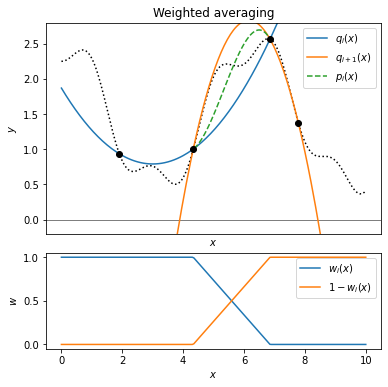

Figure 14: Weighted averaging


In [33]:
figure(14)

### Example

We wish to find the value $y(x)$ at $x=\frac{4}{3}$ of the cubic spline that passes through the points $(0,0)$, $(1,\frac{1}{2})$, $(2,2)$, and $(3,\frac{1}{2})$.

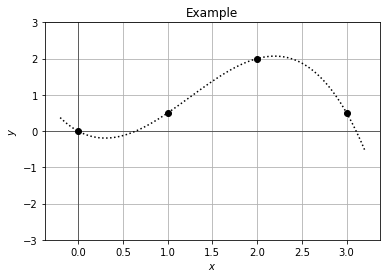

Figure 15: Example


In [34]:
figure(15)

Again, we determine that $x=\frac{4}{3}$ lies between the knots $x_{\text{knot},2}=1$ and $x_{\text{knot},3}=2$, and is therefore on the segment of the piecewise cubic polynomial between data points $(x_2, y_2) = (1, \frac{1}{2})$ and $(x_3, y_3) = (2, 2)$.

* The left parabola through $(0,0)$, $(1,\frac{1}{2})$, and $(2,2)$, as found using Lagrange or Vandermonde interpolation, equals $q_2(x) = \frac{1}{2}x^2$. Therefore, $q_2(\frac{4}{3}) = \frac{8}{9}$.

* The right parabola through $(1,\frac{1}{2})$, $(2,2)$, and $(3,\frac{1}{2})$, as found using Lagrange or Vandermonde interpolation, equals $q_3(x) = -\frac{3}{2}x^2 + 6x - 4$. Therefore, $q_3(\frac{4}{3}) = \frac{4}{3}$.

The applicable weight for the left polynomial equals $2-x = 2-\frac{4}{3} = \frac{2}{3}$ (decreasing from 1 to 0 between $x=1$ and $x=2$), and that for the right polynomial equals $x-1 = \frac{4}{3}-1 = \frac{1}{3}$ (increasing from 0 to 1 between $x=1$ and $x=2$).

Now, $y(\frac{4}{3}) = \frac{2}{3} \cdot \frac{8}{9} + \frac{1}{3} \cdot \frac{4}{3} = \frac{28}{27}$.

### Exercise 14

Manually determine the value $y(x)$ at coordinate $x=3$ for the uniform cubic spline that passes through the points $(0,-1)$, $(2,0)$, $(4,3)$, $(6,3)$, $(8,3)$, and $(10,1)$.

### Exercise 15

Complete the below skeleton function `cubic_interpolate()` that interpolates between a number of given data points that are specified in arrays `xi` and `yi` using cubic spline interpolation, and calculates the $y$-values that correspond with all the $x$-values that are requested.

```python
def cubic_interpolate(xi, yi, x):
    """y = cubic_interpolate(xi, yi, x).
    Cubic spline interpolation method that fits a
    piecewise polynomial of degree three through
    data points {xi,yi}, evaluated at arguments x.
    xi     = {x1,x2,...,xn}
    yi     = {y1,y2,...,xn}
    x      = arguments x
    """
    if xi.size != yi.size:
        raise ValueError('xi and yi must have the same length')
    order = np.argsort(xi)
    xi, yi = xi[order], yi[order]
    pass   # ADD YOUR OWN CODE HERE
    return y
```

### Exercise 16

Apply your own function `cubic_interpolate()` to verify your solution for exercise 14.

y(3.0) = 1.5625


### Exercise 17

Compare the output of your own function `cubic_interpolate()` to that of `scipy`'s `interp1d(kind='cubic')` function for the data from exercise 1.

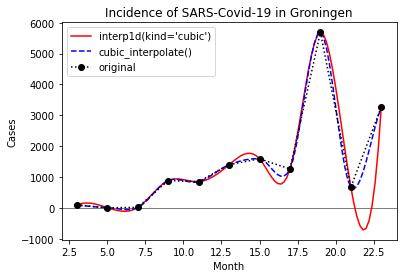

### End of lesson 2

Congratulations for finishing this lesson!

* Run your full notebook from scratch to ensure it works correctly (i.e., `Kernel` > `Restart & Run All`).

* Save your working version (i.e., `File` > `Save and Checkpoint`).

* Submit your completed notebook on [BlackBoard](https://blackboard.hanze.nl).

If handed in on time, you will be provided with feedback on your implementation of the `cubic_interpolate()` function in **Part 2D**.

***